<a href="https://colab.research.google.com/github/OscarIraira23/MachineLearning/blob/main/Classificator_leaf_beans_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
# Enable eager execution
tf.enable_v2_behavior()

# Check out all available datasets 
#tfds.list_builders()

In [ ]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name = 'beans', 
    split = ['train', 'validation', 'test'],
    as_supervised = True,
    with_info = True)
#print(ds_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteJKH31Y/beans-train.tfrecord


  0%|          | 0/1034 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteJKH31Y/beans-validation.tfrecord


  0%|          | 0/133 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteJKH31Y/beans-test.tfrecord


  0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)

def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label

ds_train = ds_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_validation = ds_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(ds_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(ds_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(ds_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


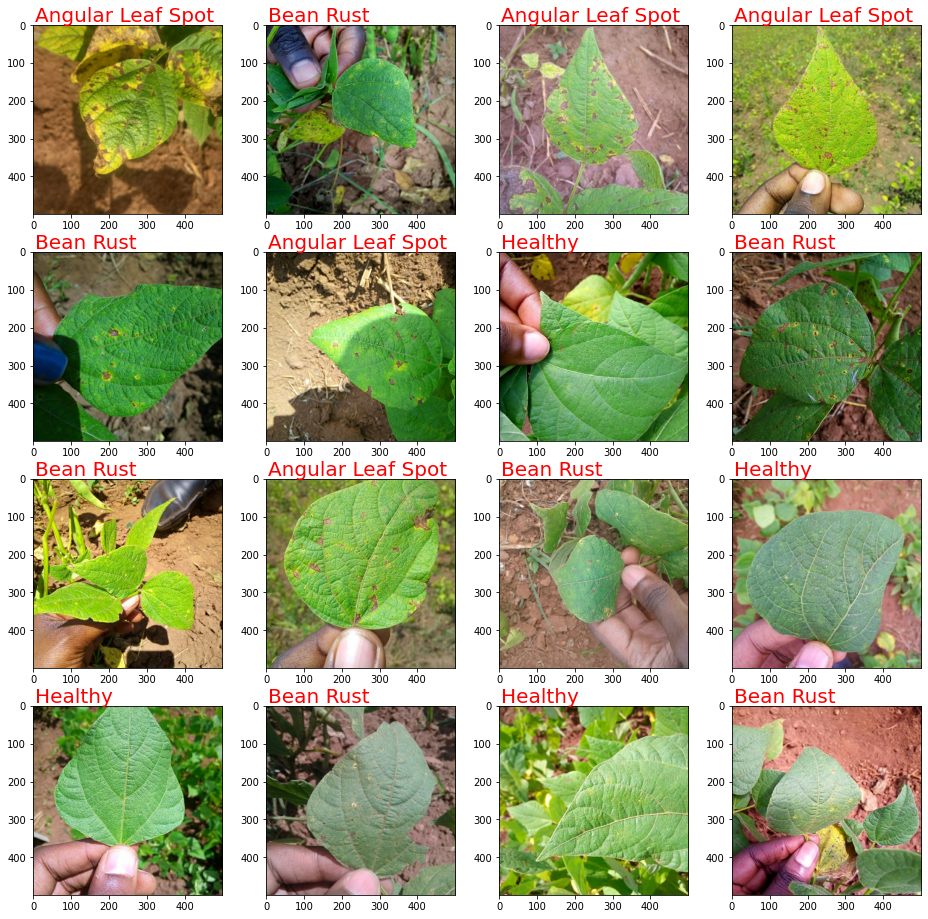

In [ ]:
example = ds_train.take(1)
for sample in example:
    image, label = sample[0], sample[1]
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

In [ ]:
num_filters = 15
filter_size = 10
pool_size = 4
strides = 2
fc_output = 128
drop_probability = 0.25
learning_rate = 0.001

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(num_filters, filter_size, input_shape = (image_height, image_width, 3),
                        strides = strides, padding = 'same', activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = pool_size),
  tf.keras.layers.Dropout(drop_probability),
  tf.keras.layers.Conv2D(num_filters, filter_size, strides = strides, padding = 'same', 
                         activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = pool_size),
  tf.keras.layers.Dropout(drop_probability),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(fc_output, activation = 'relu'),

  tf.keras.layers.Dense(num_classes, activation = 'softmax'),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 15)      4515      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 15)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 15)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 15)        22515     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 15)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 15)          0

In [ ]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy'],
)

In [ ]:
num_epochs = 20
history = model.fit(
    ds_train,
    epochs = num_epochs,
    validation_data = ds_validation,
)

Epoch 1/20
33/33 [==============================] - 137s 4s/step - loss: 1.1156 - accuracy: 0.3191 - val_loss: 1.0986 - val_accuracy: 0.3233
Epoch 2/20
33/33 [==============================] - 136s 4s/step - loss: 1.0988 - accuracy: 0.3191 - val_loss: 1.0982 - val_accuracy: 0.4060
Epoch 3/20
33/33 [==============================] - 135s 4s/step - loss: 1.0923 - accuracy: 0.3607 - val_loss: 1.0711 - val_accuracy: 0.3459
Epoch 4/20
33/33 [==============================] - 136s 4s/step - loss: 1.0622 - accuracy: 0.4691 - val_loss: 0.9529 - val_accuracy: 0.5263
Epoch 5/20
33/33 [==============================] - 135s 4s/step - loss: 0.9428 - accuracy: 0.5503 - val_loss: 0.9934 - val_accuracy: 0.4887
Epoch 6/20
33/33 [==============================] - 134s 4s/step - loss: 0.8574 - accuracy: 0.5783 - val_loss: 0.7631 - val_accuracy: 0.6617
Epoch 7/20
33/33 [==============================] - 136s 4s/step - loss: 0.7302 - accuracy: 0.6460 - val_loss: 0.7044 - val_accuracy: 0.7143
Epoch 8/20
33

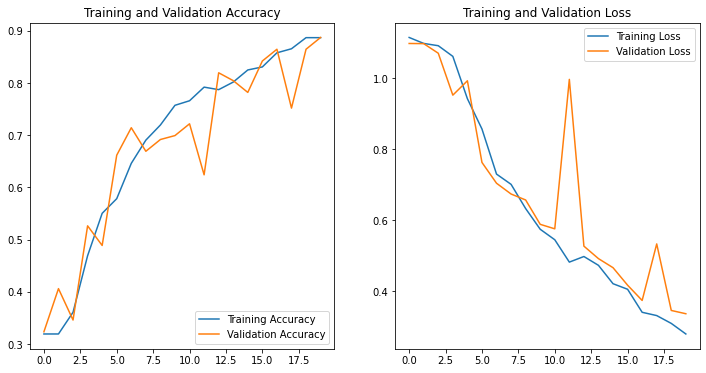

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(ds_test)
print('n Final test accuracy:', test_acc)

4/4 [==============================] - 10s 2s/step - loss: 0.4323 - accuracy: 0.8125
n Final test accuracy: 0.8125


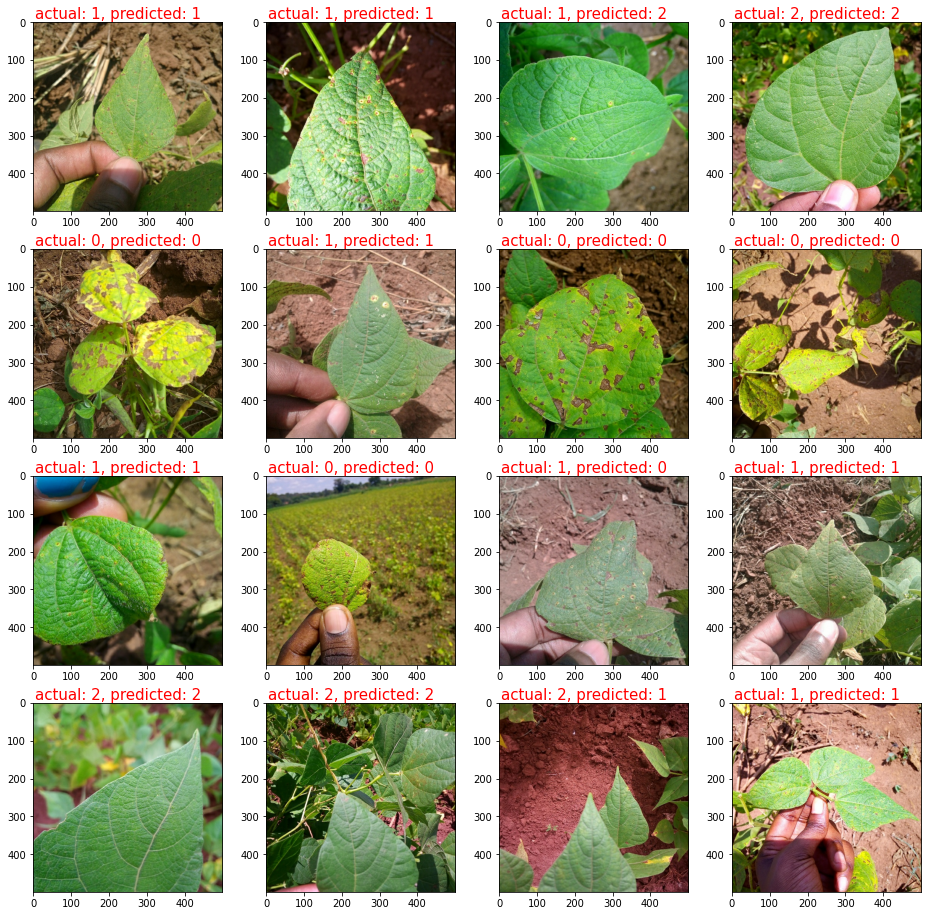

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
normalized_probs = probability_model.predict(ds_test)
predicted_labels = np.argmax(normalized_probs, axis = 1)
actual_labels = return_class_labels(ds_test)

# Looking at test images
example = ds_test.take(1)
for sample in example:
    image = sample[0]
    image = image.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "actual: " + str(actual_labels[i]) + ", predicted: " + str(predicted_labels[i]) ,
            color = 'red', fontsize = 15)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))